<a href="https://colab.research.google.com/github/malloyca/CSC581B/blob/main/Final%20Project/small_convnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notes

- Complete trial with eight layer model
- Add batch normalization
- Add more feedback to early stopping
  - accuracy and loss for that epoch
- Ideas for improving the performance

In [90]:
# imports
import torch
from torch import nn
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.datasets import CIFAR100
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import copy
import numpy as np
import random


This cell sets up the data augmentation methods.

In [91]:
# data augmentation transforms
data_augmentation_transform = transforms.Compose([
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.RandomRotation(degrees=30),
  transforms.RandomCrop(32, padding=2),
  transforms.ColorJitter(brightness=0.25, contrast=0.5, saturation=0.25, hue = 0.15),
  transforms.RandomGrayscale(p=0.2),
  transforms.ToTensor(),
  transforms.Normalize(
      mean = [0.5071, 0.4867, 0.4408],
      std = [0.2675, 0.2565, 0.2761]
  ),
  transforms.RandomErasing(p=.35),
])

In [92]:
# non-augmentation transform (with data normalization)
normalize_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(
      mean = [0.5071, 0.4867, 0.4408],
      std = [0.2675, 0.2565, 0.2761]
  )
])

In [93]:
# Load the training data (CIFAR10 to start)
training_data_with_augmentation = CIFAR100(
    root = "data",
    train = True,
    download = True,
    transform = data_augmentation_transform,
)

training_data_without_augmentation = CIFAR100(
    root = "data",
    train = True,
    download = True,
    transform = normalize_transform,
)

# this is necessary to prevent the data augmentation transforms from being applied to the validation set
validation_data = CIFAR100(
    root = "data",
    train = True,
    download = True,
    transform = normalize_transform,
)

# Load the test data
test_data = CIFAR100(
    root = "data",
    train = False,
    download = True,
    transform = transforms.ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [94]:
training_targets = training_data_with_augmentation.targets

In [95]:
train_split_index, valid_split_index = train_test_split(
    np.arange(len(training_targets)), test_size=0.2, stratify=training_targets
)

In [96]:
batch_size = 100

# Create data loaders
train_augmentation_dataloader = DataLoader(training_data_with_augmentation, batch_size=batch_size,
                              sampler=SubsetRandomSampler(train_split_index))
train_no_augmentation_dataloader = DataLoader(training_data_without_augmentation, batch_size=batch_size,
                              sampler=SubsetRandomSampler(train_split_index))
valid_dataloader = DataLoader(validation_data, batch_size=batch_size,
                              sampler=SubsetRandomSampler(valid_split_index))
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [97]:
train_status = True

In [98]:
if not train_status:
  # Check that it is splitting the data properly
  train_length = 0
  for _, y in train_augmentation_dataloader:
    train_length += len(y)
  print(f"Length of training (augmentation) split: {train_length}")

  train_aug_length = 0
  for _, y in train_no_augmentation_dataloader:
    train_aug_length += len(y)
  print(f"Length of training (no augmentation) split: {train_aug_length}")

  valid_length = 0
  for _, y in valid_dataloader:
    valid_length += len(y)
  print(f"Length of validation split: {valid_length}")

  test_length = 0
  for _, y in test_dataloader:
    test_length += len(y)
  print(f"Length of test split: {test_length}")

In [99]:
if not train_status:
  # Check that there are 100 instances of a random class in the validation set
  count = 0
  test_class = random.randint(0,99)
  for _, y in valid_dataloader:
    for target in y:
      if int(target.numpy()) == test_class:
        count += 1

  print(count)

# Building basic convolutional neural nets

In [36]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [37]:
# Define the model
class basicConvNet(nn.Module):
  def __init__(self, name):
    super(basicConvNet, self).__init__()
    self.name = name
    self.basic_conv_net = nn.Sequential(
        # 1st layer
        nn.Conv2d(3, 50, (3,3), padding='same'),
        #nn.BatchNorm2d(50),
        nn.ReLU(),
        #nn.Dropout2d(p=0.1),
        
        # 2nd layer
        nn.Conv2d(50, 75, (3,3), padding='same'),
        #nn.BatchNorm2d(75),
        nn.ReLU(),
        #nn.Dropout2d(p=0.1),
        nn.MaxPool2d(2),
        
        # 3rd layer - 16x16
        nn.Conv2d(75, 100, (3,3), padding='same'),
        #nn.BatchNorm2d(100),
        nn.ReLU(),
        #nn.Dropout2d(p=0.1),
        
        # 4th layer
        nn.Conv2d(100, 150, (3,3), padding='same'),
        #nn.BatchNorm2d(150),
        nn.ReLU(),
        #nn.Dropout2d(p=0.1),
        nn.MaxPool2d(2),
        
        # 5th layer - 8x8
        nn.Conv2d(150, 200, (3,3), padding='same'),
        #nn.BatchNorm2d(200),
        nn.ReLU(),
        #nn.Dropout2d(p=0.1),
        
        # 6th layer
        nn.Conv2d(200, 250, (3,3), padding='same'),
        #nn.BatchNorm2d(250),
        nn.ReLU(),
        #nn.Dropout2d(p=0.1),
        nn.MaxPool2d(2),
        
        # 7th layer - 4x4
        nn.Flatten(),
        nn.Linear(250*4*4, 1000),
        nn.ReLU(),
        #nn.Dropout(p=0.2),
        
        # 8th layer
        nn.Linear(1000, 500),
        nn.ReLU(),
        #nn.Dropout(p=0.2),
        nn.Linear(500, 100)
    )


  # Forward propagation
  def forward(self, x):
    x = self.basic_conv_net(x)
    #x = self.flatten(x)
    #x = self.output(x)
    return x
      

In [38]:
# Define the model
class basicConvNet(nn.Module):
  def __init__(self, name):
    super(basicConvNet, self).__init__()
    self.name = name
    self.basic_conv_net = nn.Sequential(
        # 1st layer
        nn.Conv2d(3, 100, (3,3), padding='same'),
        #nn.BatchNorm2d(50),
        nn.ReLU(),
        #nn.Dropout2d(p=0.1),
        
        # 2nd layer
        nn.Conv2d(100, 150, (3,3), padding='same'),
        #nn.BatchNorm2d(75),
        nn.ReLU(),
        #nn.Dropout2d(p=0.1),
        nn.MaxPool2d(2),
        
        # 3rd layer - 16x16
        nn.Conv2d(150, 200, (3,3), padding='same'),
        #nn.BatchNorm2d(100),
        nn.ReLU(),
        #nn.Dropout2d(p=0.1),
        
        # 4th layer
        nn.Conv2d(200, 250, (3,3), padding='same'),
        #nn.BatchNorm2d(150),
        nn.ReLU(),
        #nn.Dropout2d(p=0.1),
        nn.MaxPool2d(2),
        
        # 5th layer - 8x8
        nn.Conv2d(250, 300, (3,3), padding='same'),
        #nn.BatchNorm2d(200),
        nn.ReLU(),
        #nn.Dropout2d(p=0.1),
        
        # 6th layer
        nn.Conv2d(300, 400, (3,3), padding='same'),
        #nn.BatchNorm2d(250),
        nn.ReLU(),
        #nn.Dropout2d(p=0.1),
        nn.MaxPool2d(2),
        
        # 7th layer - 4x4
        nn.Flatten(),
        nn.Linear(400*4*4, 1000),
        nn.ReLU(),
        #nn.Dropout(p=0.2),
        
        # 8th layer
        nn.Linear(1000, 500),
        nn.ReLU(),
        #nn.Dropout(p=0.2),
        nn.Linear(500, 100)
    )


  # Forward propagation
  def forward(self, x):
    x = self.basic_conv_net(x)
    #x = self.flatten(x)
    #x = self.output(x)
    return x
      

In [39]:
# This is the current winner for best performing architecture

# Define the model
class basicConvNet(nn.Module):
  def __init__(self, name, dropout_conv=0.1, dropout_linear=0.2):
    super(basicConvNet, self).__init__()
    self.name = name
    self.basic_conv_net = nn.Sequential(
        # 1st layer
        nn.Conv2d(3, 50, (3,3), padding='same'),
        nn.BatchNorm2d(50),
        nn.ReLU(),
        nn.Dropout2d(p=dropout_conv),
        
        # 2nd layer
        nn.Conv2d(50, 100, (3,3), padding='same'),
        nn.BatchNorm2d(100),
        nn.ReLU(),
        nn.Dropout2d(p=dropout_conv),
        nn.MaxPool2d(2),
        
        # 3rd layer - 16x16
        nn.Conv2d(100, 150, (3,3), padding='same'),
        nn.BatchNorm2d(150),
        nn.ReLU(),
        nn.Dropout2d(p=dropout_conv),
        
        # 4th layer
        nn.Conv2d(150, 200, (3,3), padding='same'),
        nn.BatchNorm2d(200),
        nn.ReLU(),
        nn.Dropout2d(p=dropout_conv),
        nn.MaxPool2d(2),
        
        # 5th layer - 8x8
        nn.Conv2d(200, 300, (3,3), padding='same'),
        nn.BatchNorm2d(300),
        nn.ReLU(),
        nn.Dropout2d(p=dropout_conv),
        
        # 6th layer
        nn.Conv2d(300, 400, (3,3), padding='same'),
        nn.BatchNorm2d(400),
        nn.ReLU(),
        nn.Dropout2d(p=dropout_conv),
        nn.MaxPool2d(2),
        
        # 7th layer - 4x4
        nn.Flatten(),
        nn.Linear(400*4*4, 1000),
        nn.ReLU(),
        nn.Dropout(p=dropout_linear),
        
        # 8th layer
        nn.Linear(1000, 500),
        nn.ReLU(),
        nn.Dropout(p=dropout_linear),
        nn.Linear(500, 100)
    )


  # Forward propagation
  def forward(self, x):
    x = self.basic_conv_net(x)
    #x = self.flatten(x)
    #x = self.output(x)
    return x
      

In [41]:
# Training function
def train(dataloader, batch_size, model, loss_fn, optimizer):
  num_batches = len(dataloader)
  size = num_batches * batch_size
  model.train()
  train_loss, num_correct = 0, 0
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # Compute prediction error
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Track train_loss and accuracy
    train_loss += loss.item()
    num_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    if batch % 100 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

  train_loss /= num_batches
  accuracy = num_correct / size
  return train_loss, accuracy

In [43]:
# Validation function
def validation(dataloader, batch_size, model, loss_fn):
  num_batches = len(dataloader)
  size = num_batches * batch_size
  model.eval()
  val_loss, num_correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      val_loss += loss_fn(pred, y).item()
      num_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  val_loss /= num_batches
  accuracy = num_correct / size
  print(f"Validation Error: \n Validation accuracy: {(100 * accuracy):>0.1f}%, Validation loss: {val_loss:>8f} \n")
  return val_loss, accuracy

In [44]:
# Test function
def test(dataloader, model, loss_fn):
  size = len(dataloader.dataset)
  num_batches = len(dataloader)
  model.eval()
  test_loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      test_loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  test_loss /= num_batches
  correct /= size
  print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
  return test_loss

In [45]:
def training_loop(n_epochs, model, train_data, valid_data, batch_size,
                  loss_function, optimizer, scheduler=None,
                  early_stopping=False, patience=10):
  current_epoch = 0
  best_epoch = 0
  best_loss = float('inf')
  patience_counter = 0

  train_losses = []
  train_accuracies = []
  val_losses = []
  val_accuracies = []

  for e in range(n_epochs):
    print(f"\nEpoch {e+1}\n----------------------------")
    # Iterate epoch counter
    current_epoch += 1

    train_loss, train_accuracy = train(train_data, batch_size, model, loss_function, optimizer)
    val_loss, val_accuracy = validation(valid_data, batch_size, model, loss_function)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Iterate scheduler (this is set up for ReduceLROnPlateau)
    if scheduler is not None:
      scheduler.step(val_loss)

    # If early_stopping check test_loss
    if early_stopping:
      # case: test loss beats the current best loss
      if val_loss < best_loss:
        # store loss
        best_loss = val_loss

        # reset patience counter
        patience_counter = 0

        # store model and epoch number
        print("Storing new best model.")
        best_model_state_dict = copy.deepcopy(model.state_dict)
        best_epoch = current_epoch

      # Case: patience limit not yet reached => iterate patience counter
      elif patience_counter < patience - 1:
        patience_counter += 1
        print(f"Patience count: {patience_counter}")

      # Case: patience limit reached
      else:
        print("Finished due to early stopping.")
        print(f"Saving best model: {model.name}_epoch-{best_epoch:03d}")
        torch.save(best_model_state_dict, f'{model.name}_epoch-{best_epoch:03d}')
        break

  # If we get here, we did not stop early - save best model
  if early_stopping:
    print(f"Saving best model: {model.name}_epoch-{best_epoch:03d}")
    torch.save(best_model_state_dict, f'{model.name}_epoch-{best_epoch:03d}')
  else:
    print()

  return train_losses, train_accuracies, val_losses, val_accuracies

# Training

In [115]:
n_epochs = 100

In [116]:
model = basicConvNet(name='eight-layer', dropout_conv=0.1, dropout_linear=0.15).to(device)
num_param = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {num_param:,}")

Total number of parameters: 9,026,550


In [117]:
model_aug = basicConvNet(name='eight-layer', dropout_conv=0.1, dropout_linear=0.15).to(device)
num_param = sum(p.numel() for p in model_aug.parameters())
print(f"Total number of parameters: {num_param:,}")

Total number of parameters: 9,026,550


In [118]:
# Loss function
loss_fn = nn.CrossEntropyLoss()
loss_fn_aug = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
optimizer_aug = torch.optim.Adam(model_aug.parameters(), lr=5e-5)

# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', patience=5)
scheduler_aug = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer_aug, mode='min', patience=5)

In [ ]:
train_loss, train_accuracy, val_loss, val_accuracy = training_loop(n_epochs, model, train_no_augmentation_dataloader, valid_dataloader, batch_size,
              loss_fn, optimizer, scheduler, early_stopping=True, patience=10)


Epoch 1
----------------------------
loss: 4.612765 [    0/40000]
loss: 4.470747 [10000/40000]
loss: 3.906359 [20000/40000]
loss: 3.933793 [30000/40000]


### LR results after 3 epochs
- `1e-1` => no learning
- `1e-2` => no learning
- `1e-3` => 12.6% / 3.714641
- `1e-4` => 20.5% / 3.270644
- `5e-5` => 
- `1e-5` => 14.5% / 3.715099

In [ ]:
plt.figure(figsize=(15,8))
plt.title(f"Train and Validation Loss for {model.name}")
plt.plot(val_loss, label="val_loss")
plt.plot(train_loss, label="train_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show

In [ ]:
plt.figure(figsize=(15,8))
plt.title(f"Train and Validation Accuracy for {model.name}")
plt.plot(val_accuracy, label="val_accuracy")
plt.plot(train_accuracy, label="train_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show

## Training with data augmentation

In [ ]:
train_loss_aug, train_accuracy_aug, val_loss_aug, val_accuracy_aug = training_loop(n_epochs, model_aug, train_augmentation_dataloader, valid_dataloader, batch_size,
              loss_fn_aug, optimizer_aug, scheduler_aug, early_stopping=True, patience=10)

In [ ]:
plt.figure(figsize=(15,8))
plt.title(f"Train and Validation Loss for {model.name} with Data Augmentation")
plt.plot(val_loss_aug, label="val_loss")
plt.plot(train_loss_aug, label="train_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show

In [ ]:
plt.figure(figsize=(15,8))
plt.title(f"Train and Validation Accuracy for {model.name}")
plt.plot(val_accuracy_aug, label="val_accuracy")
plt.plot(train_accuracy_aug, label="train_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show

# Results

---

Model with data augmentation and `lr=5e-4` for 50 epochs: **Validation accuracy: 54.7%, Validation loss: 1.657589**.

<function matplotlib.pyplot.show>

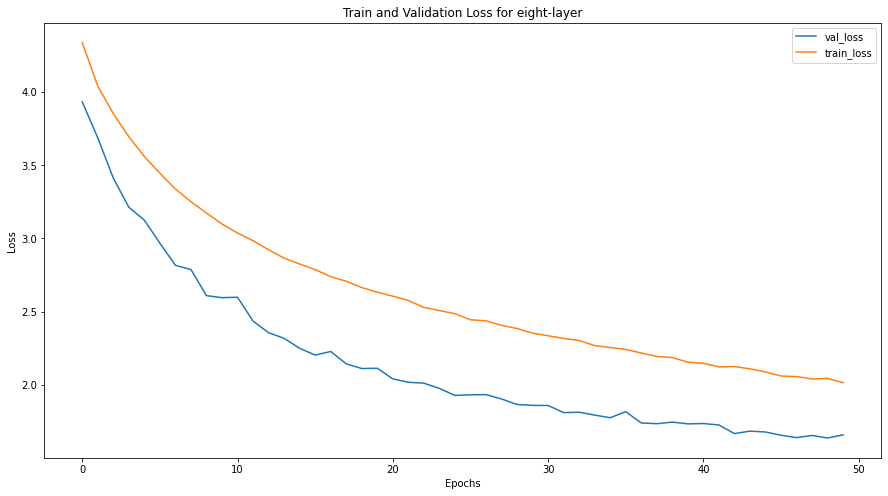

In [37]:
plt.figure(figsize=(15,8))
plt.title(f"Train and Validation Loss for {model.name}")
plt.plot(val_loss, label="val_loss")
plt.plot(train_loss, label="train_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show

<function matplotlib.pyplot.show>

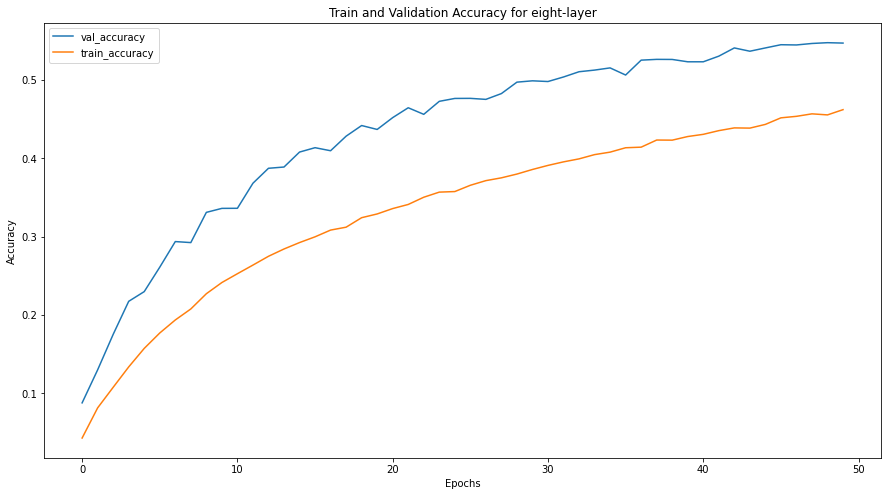

In [38]:
plt.figure(figsize=(15,8))
plt.title(f"Train and Validation Accuracy for {model.name}")
plt.plot(val_accuracy, label="val_accuracy")
plt.plot(train_accuracy, label="train_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show